<center><img src="Logo/logo4.png" width="250" height="250" align="center"/><center>
    

# <center>A Python Tool for Calculating Maximum Depositional Ages Using Detrital Zircon Data<center> 

# 1. Import Modules
First, execute the following by selecting the cell below and pressing return+shift

In [2]:
import MDAPy_Functions as MDAFunc
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font
import numpy as np
import seaborn as sns
import math 
import peakutils

# 2. Load Data

In this step you will load your data into the tool using a pre-formatted excel spreadsheet. Repeat this step if any changes are made to the excel file. 

Follow the instructions below: 

1. Open the excel file titled "Data_Upload" in the MDAPy/Data Directory (original MDAPy folder)
2. Opent the excel file and fill in 2 Sheets titled: "Samples" and "Data"
3. For the "Samples" sheet: you MUST fill in the Sample_ID column with all the individual samples, with one sample per row 
4. The "Data" sheet the following three columns must be filled in: 
    - Sample_ID: unique sample identifier, same as what was listed in the “Samples” worksheet
    - BestAge: the best age or accepted date calculated for each grain
    - BestAge_err_sx: the error of each individual age measurement (1$\sigma$  or 2$\sigma$)
5. Save the file and close it 
6. In the cell below: enter the file paths after dataToLoad, making sure it is written within the single quotation marks as: 'Data/Data_Upload.xlsx' 
7. You can repeat the above process and upload as many excel files as required or put all your data into one excel file. If there are multiple files, put a (,) between each  
8. Press return+shift in the cell below to load your data

### Load Sample IDs, Ages and Errors

In [3]:
Data_Type = 'Ages' #3 Options: Ages, 238U/206Pb_&_207Pb/206Pb

dataToLoad = ['Data/Data_Upload_Example_Data_Type_Ages.xlsx'] 

#other test excel spreadsheet with 'Ages' type data: dataToLoad = [''Data/Data_Upload_Example_Data_Type_Ages.xlsx'] 
#other test excel spreadsheet with Ratio type data: dataToLoad = [''Data/Data_Upload_Example_Data_Type_Ratios.xlsx'] 

main_df, main_byid_df, samples_df, analyses_df, Data_Type  = MDAFunc.loadDataExcel(dataToLoad, Data_Type)


# 3. Check That the Data Loaded Properly & Review Unique Samples

Execute the following code to examine your data and make sure it loaded correctly.

In [4]:
MDAFunc.check_data_loading(analyses_df, Data_Type)



12 unique samples were found in your data ['UK026', 'UK027', 'UK025', 'UK021', 'UK024', 'UK017', 'UK018', 'UK019', 'UK016', 'UK020', 'UK015', 'UK014'] with the following sample sizes:



,Sample_ID,Sample_Size
0,UK014,507
1,UK015,410
2,UK016,501
3,UK017,507
4,UK018,498
5,UK019,487
6,UK020,480
7,UK021,514
8,UK024,473
9,UK025,473


# 4. Select Samples and Sigma
Use the above sample list to copy the samples (in that exact format) you would like to include in your MDA calculations below. 

Copy them into the cell below and execute the code by selecting the cell and pressing shift+enter. 

The sample list must be in this exact format: with single quotation marks ('1-GB') on either side and a comma (,) between all samples.

Also specify whether the error in your data is 1$\sigma$ or 2$\sigma$. 

In [5]:
sample_list = ['UK027', 'UK025']

sigma = 2 #specify if uncertainty is 1 or 2 sigma

uncertainty = 'percent' #2 options: absolute or percent 

best_age_cut_off = 1500 #specify the age calculation cut off for switching from using: 238U/206Pb to 207Pb/206Pb: Standard is 1500 to 1550 Ma to switch to the 207Pb/206Pb calculation

U238_decay_constant = (1.55125*(10**-10))
U235_decay_constant = (9.8485*(10**-10))
U238_U235 = 137.88 

excess_variance_206_238= 1.2 
excess_variance_207_206= 0.7

Sy_calibration_uncertainty_206_238= 0.6
Sy_calibration_uncertainty_207_206= 0.6

decay_constant_uncertainty_U238= 0.16
decay_constant_uncertainty_U235= 0.20

#Errors produced for calculated ages amd MDAs are 1s ABS 

(ages, errors, eight_six_ratios, eight_six_error,
 seven_six_ratios, seven_six_error, numGrains, labels,
 sample_list, best_age_cut_off, dataToLoad_MLA,
 U238_decay_constant,U235_decay_constant,U238_U235,excess_variance_206_238,
 excess_variance_207_206, Sy_calibration_uncertainty_206_238, 
 Sy_calibration_uncertainty_207_206, decay_constant_uncertainty_U238,
 decay_constant_uncertainty_U235) = MDAFunc.sampleToData(
     sample_list, main_byid_df, sigma, Data_Type, uncertainty,
     best_age_cut_off, U238_decay_constant, U235_decay_constant,
     U238_U235,excess_variance_206_238, excess_variance_207_206,
     Sy_calibration_uncertainty_206_238, Sy_calibration_uncertainty_207_206,
     decay_constant_uncertainty_U238, decay_constant_uncertainty_U235)

filename = 'Data/ages_errors_calculated.xlsx'
wb = load_workbook(filename)
if 'Samples' in wb.sheetnames:
    sheet = wb['Samples']
    cell = sheet['A1']
    cell.value = 'id'
    cell.alignment = Alignment(horizontal='center')
    cell.font = Font(name='Arial', size=11)
    wb.save(filename)
else:
    msg = 'there is no samples sheet as the first sheet in the file'
    raise Exception(msg)
    
# this is a bit unusual as after adding the id it doesnt work, 
# only after saving the file from excel directly


# 5. MDA Calculator: Table & Plots

### MDA Summary Table
Execute the following code to compute all 10 MDA Methods: a full table of all MDA results will populate (MDAs and Errors only). An excel file titled "All_MDA_Data" will be saved in the 'Saved_Files' folder which includes all the MDAs, errors, MSWD, and grain cluster sizes. All errors (except for YDZ) are quoted in 1$\sigma$  absolute.

Please note: if your dataset is very large, calculating the MDAs and subsequent plots will take extra time. The largest dataset put through MDAPy was 13 samples of ~ 500 age measurements each, for a total of 6329 individual measurements. As a reference point, that dataset took ~ 1 minute to calculate. 

To go faster you can do smaller batches of samples, for example one sample of the same dataset took 5 seconds to load.

In [7]:
U238_decay_constant, U235_decay_constant, U238_U235, YSG_MDA, YC1s_MDA, YC1s_cluster_arrays, YC2s_MDA, YC2s_cluster_arrays, YDZ_MDA, minAges, mode, Y3Zo_MDA, Y3Zo_cluster_arrays, Y3Za_MDA, Y3Za_cluster_arrays, Tau_MDA, Tau_Grains, PDP_age, PDP,plot_max, ages_errors1s_filtered, tauMethod_WM, tauMethod_WM_err2s, YSP_MDA, YSP_cluster, YPP_MDA, MLA_MDA = MDAFunc.MDA_Calculator(ages, errors, sample_list, dataToLoad_MLA, eight_six_ratios, eight_six_error, seven_six_ratios, seven_six_error, U238_decay_constant, U235_decay_constant,U238_U235, excess_variance_206_238, excess_variance_207_206, Sy_calibration_uncertainty_206_238, Sy_calibration_uncertainty_207_206, decay_constant_uncertainty_U238, decay_constant_uncertainty_U235, Data_Type, best_age_cut_off)
MDAs_1s_table, excel_MDA_data, all_MDA_data = MDAFunc.output_tables(sample_list, YSG_MDA, YC1s_MDA, YC2s_MDA, YDZ_MDA, Y3Zo_MDA, Y3Za_MDA, Tau_MDA, YSP_MDA, YPP_MDA, MLA_MDA); MDAs_1s_table

,Sample_ID,Y3Zo_MDA,Y3Zo_+/-1$\sigma$,YSP_MDA,YSP_+/-1$\sigma$,Tau_MDA,Tau_+/-1$\sigma$,Y3Za_MDA,Y3Za_+/-1$\sigma$,YC1$\sigma$_MDA,YC1$\sigma$_+/-1$\sigma$,YC2$\sigma$_MDA,YC2$\sigma$_+/-1$\sigma$,YPP_MDA,YDZ_MDA,YDZ_+2$\sigma$,YDZ_-2$\sigma$,YSG_MDA,YSG_+/-1$\sigma$,MLA_MDA,MLA_+/-1$\sigma$
0,UK027,67.83,1.86,72.33,1.10,87.95,1.21,67.83,1.86,70.01,1.19,73.19,1.09,86.30,64.84,2.80,4.18,67.33,2.60,72.32,1.32
1,UK025,73.90,1.74,74.38,1.67,77.38,1.34,73.90,1.74,73.46,1.84,77.38,1.34,78.60,70.51,3.75,4.77,71.16,2.91,71.16,2.46


### MDA Method Comparison Plots
Execute the following code to plot all MDA methods for each sample with the associated 1$\sigma$  & 2$\sigma$  uncertainties. Choose your plot size below. A PDF of the plots will be saved in the 'Saved_Files' folder titled "MDA_Plots.pdf". For a detailed explanation of each MDA method, see below.   

In [ ]:
plotwidth = 10
plotheight = 7

Image_File_Option = 'tiff' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

MDAfig, MDA_plot_final = MDAFunc.Plot_MDA(MDAs_1s_table, all_MDA_data, sample_list, YSG_MDA, YC1s_MDA, YC2s_MDA, YDZ_MDA, Y3Zo_MDA, Y3Za_MDA, Tau_MDA, YSP_MDA, YPP_MDA, MLA_MDA, Image_File_Option, plotwidth, plotheight)

### MDA Stratigraphic Plot (One Method / All Samples) 

To view all your samples on one plot with one MDA method execute the following code. This will plot one MDA method for all samples with the associated 1$\sigma$  & 2$\sigma$  uncertainties. Choose your MDA method and plot size below or put in 'All' to see all the plots at once. A PDF of the plots will be saved in the 'Saved_Files' folder titled "MDA_Stratigraphic_Plots.pdf"

In [ ]:
plotwidth = 12
plotheight = 9

Image_File_Option = 'jpeg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

MDA_Method = "YSG" #Input = YSG, YC1s, YC2s, YDZ, Y3Zo, Y3Za, Tau, YSP, YPP, MLA, OR All 

Plot = MDAFunc.MDA_Strat_Plot(YSG_MDA, YC1s_MDA, YC2s_MDA, YDZ_MDA, Y3Zo_MDA, Y3Za_MDA, Tau_MDA, YSP_MDA, YPP_MDA, MLA_MDA, ages, errors, sample_list, Image_File_Option, plotwidth, plotheight, MDA_Method);


# 6. Calculating Individual MDA Methods

### 1. YSG: Youngest Single Grain 

The youngest single grain (YSG) as described in in Dickinson and Gehrels (2009), uses the youngest single detrital zircon grain age and uncertainty measured within the sample as the MDA. If the YSG has a 1σ uncertainty >10 Ma and overlaps with the second-youngest date, then the later should be substituted for greater precision. The uncertainty of the youngest grain is used as the uncertainty of the MDA (Dickinson and Gehrels, 2009). Following Sharman et al. (2018), MDAPy takes an array of grain ages and the associated uncertainties, adds 1σ uncertainty to each age measurement, sorts them in ascending order and selects the first grain on the list as the youngest single grain and MDA. This method is contrary to Dickinson and Gehrels (2009), which does not add 1σ to the grain age before sorting and selecting the youngest grain. When done this way, older, less uncertain grains may be selected over younger more uncertain ones, as the older grain with a smaller added uncertainty could end up being younger once the 1σ uncertainties are added. 

The YSG algorithm outputs a table of calculated YSG MDAs and the corresponding 1σ uncertainty for each sample as well as plots illustrating the grain age measurements with 1σ and 2σ uncertainty bars, sorted from youngest grain age, with the YSG/MDA highlighted in red. The plots give a visual of the distribution of grain age measurements present in the sample, as well as where the YSG fits within this distribution. This visual can assist users in discerning the validity and precision of the YSG method.  

,YSG_MDA (Ma),YSG_+/-1$\sigma$
UK027,67.33,2.60
UK025,71.16,2.91


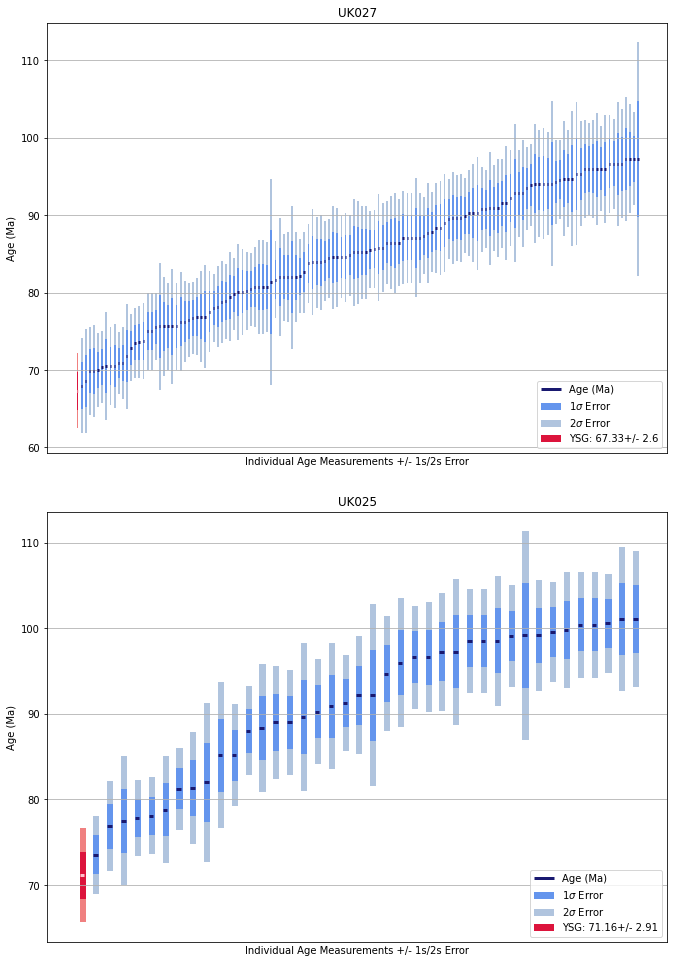

In [10]:
plotwidth = 10
plotheight = 7

#Set up max age plotted on age plots: This number age will be added to the age of the YSG: giving a max plotting age
age_addition_set_max_plot = 30

Image_File_Option = 'pdf' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YSG_MDA, YSG_Table_ = MDAFunc.YSG_outputs(ages, errors, plotwidth, plotheight, sample_list, YSG_MDA, age_addition_set_max_plot, Image_File_Option); YSG_Table_

### 2. YDZ: Youngest Detrital Zircon 
The youngest detrital zircon (YDZ)(Dickinson and Gehrels, 2009) is based on an algorithm originally developed in Isoplot (a Visual Basic add-in for Microsoft Excel) (Ludwig, 2012). In MDAPy, the YDZ algorithm is written in Python but follows the same methods of Ludwig (2012), where a Monte Carlo simulation is applied on the youngest sub-sample of ages. The simulation is applied as follows:
-	Starts with an array of ages and associated uncertainties for each sample
-	Ages are sorted in ascending order, and a sub-sample is selected which consists of all grains within 5σ of the youngest grain. This is considered the youngest sub-sample of ages.
-	The simulation runs and each iteration consists of taking the sub-sample of the youngest ages and adjusting them by a random amount of their corresponding uncertainties. From this new random array of ages, the youngest grain is selected.
-	The simulation is repeated 10,000 times and the result is 10,000 of the youngest ages from each simulation.
-	The 10,000 youngest ages are then plotted on a histogram and the mode is selected as the best estimate of the youngest detrital zircon and the MDA of the sample.
-	The upper uncertainty (P97.5) and lower uncertainty (P2.5), which are the ages where only 2.5% of dates are older or younger, define the 2σ uncertainties at 95% confidence. In general, the distribution is asymmetric which results in unequal upper and lower uncertainties. 

The resulting plots in MDAPy display frequency histograms of the distribution of the 10,000 youngest ages derived from the Monte Carlo simulation for each sample. The mode (YDZ/MDA) is highlighted in red and the upper and lower uncertainties are highlighted in black dashed lines.

Due to the nature of this calculation method: systematic uncertainties are NOT added to the final MDA uncertainties 

,YDZ_MDA (Ma),YDZ_+2$\sigma$,YDZ_-2$\sigma$
UK027,64.96,2.80,4.39
UK025,71.01,3.30,5.35


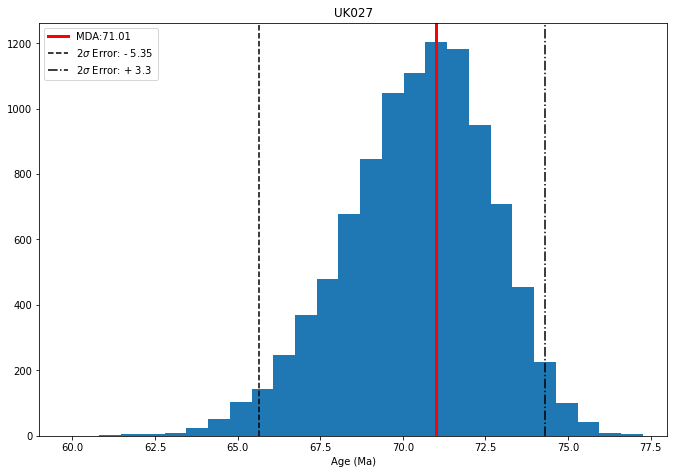

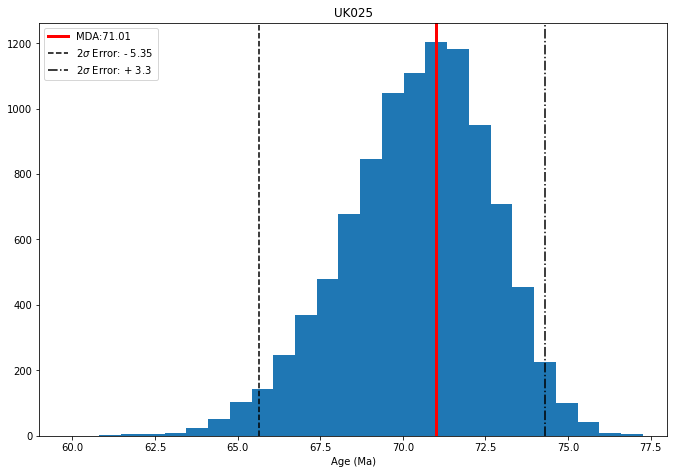

In [11]:
plotwidth = 10
plotheight = 7

Image_File_Option = 'pdf' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YDZ_MDAs, YDZ_Table_ = MDAFunc.YDZ_outputs(YDZ_MDA, minAges, mode, ages, errors, sample_list, plotwidth, plotheight, Image_File_Option); YDZ_Table_

### 3. YPP: Youngest Graphical Peak 
The youngest graphical peak (YPP) method from Dickinson and Gehrels (2009), is derived from the youngest peak (mode) on an age probability density plot (PDP) which consists of two or more grains that overlap within 2σ uncertainty. There is no uncertainty for MDAs calculated using this method. The outputs for the YPP algorithm consist of a table of the calculated YPP MDA values as well as the PDPs for each sample. The MDA values are highlighted, with a red line intersecting the youngest graphical peak (mode) with 2 or more grains that overlap within 2σ uncertainty. The x-axis is set from 0 to MDA + 200 Ma to highlight the youngest peaks within the PDP distribution. 

,YPP_MDA (Ma)
UK027,86.30
UK025,78.60


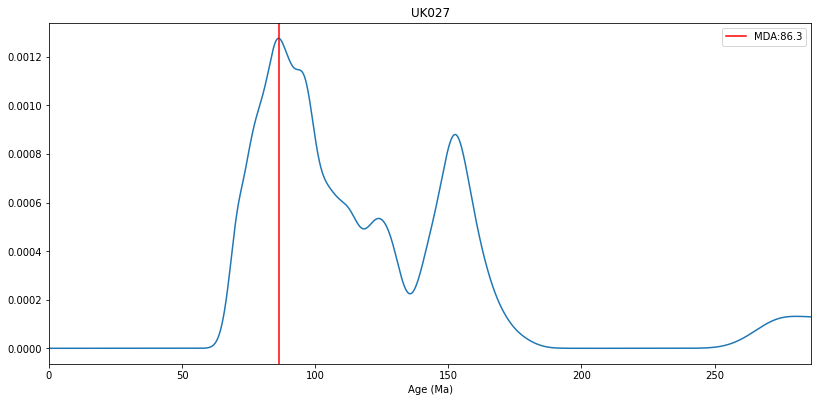

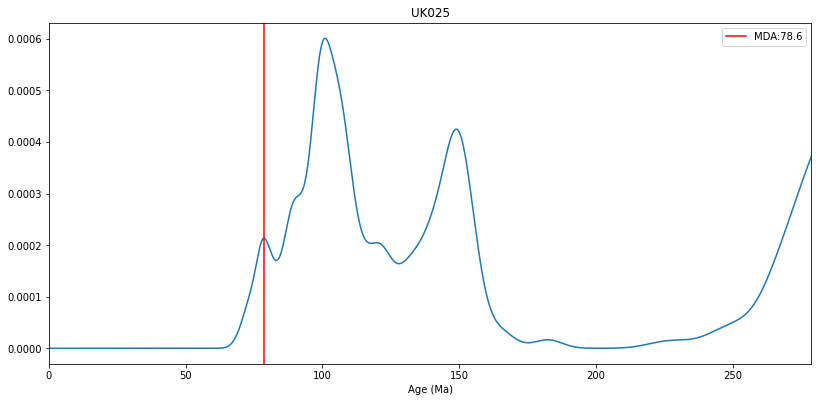

In [10]:
plotwidth = 12
plotheight = 6

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YPP_MDAs, YPP_Table_ = MDAFunc.YPP_outputs(ages, errors, sample_list, plotwidth, plotheight, Image_File_Option, sigma=1, min_cluster_size=2, thres=0.01, minDist=1, xdif=0.1); YPP_Table_

### 4. YC1$\sigma$ (2+): Youngest Grain Cluster at 1$\sigma$ 
The youngest grain cluster at 1σ uncertainty (YC1σ), is calculated using the weighted mean age, weighted by the square of the age uncertainty (Dickinson and Gehrels, 2009). The grain cluster used within the weighted mean age calculation consists of the youngest two or more grains that overlap within 1σ uncertainty. The uncertainty of the YC1σ MDA is calculated as the standard error of the calculated weighted mean age. 

The YC1σ algorithm outputs a summary table and plots of the age measurements. The table lists by sample, the MDA value, 1σ uncertainty, MSWD, and number of grains within the youngest grain cluster that were included in the weighted mean age calculation. The plots display grain ages and the corresponding 1σ and 2σ uncertainty upper and lower limit bars. The ages are sorted in ascending order and include up to 10 Ma above the oldest age within the youngest grain cluster. This restriction allows enough grains to show the grain cluster without showing all the measurements. The red bars illustrate the grains within the youngest grain cluster. The MDA is shown on the plots as a dashed line.

,YC1$\sigma$_MDA (Ma),YC1$\sigma$_+/-1$\sigma$,YC1$\sigma$_MSWD,YC1$\sigma$_Grains
UK027,70.01,1.19,0.22,13
UK025,73.46,1.84,0.94,3


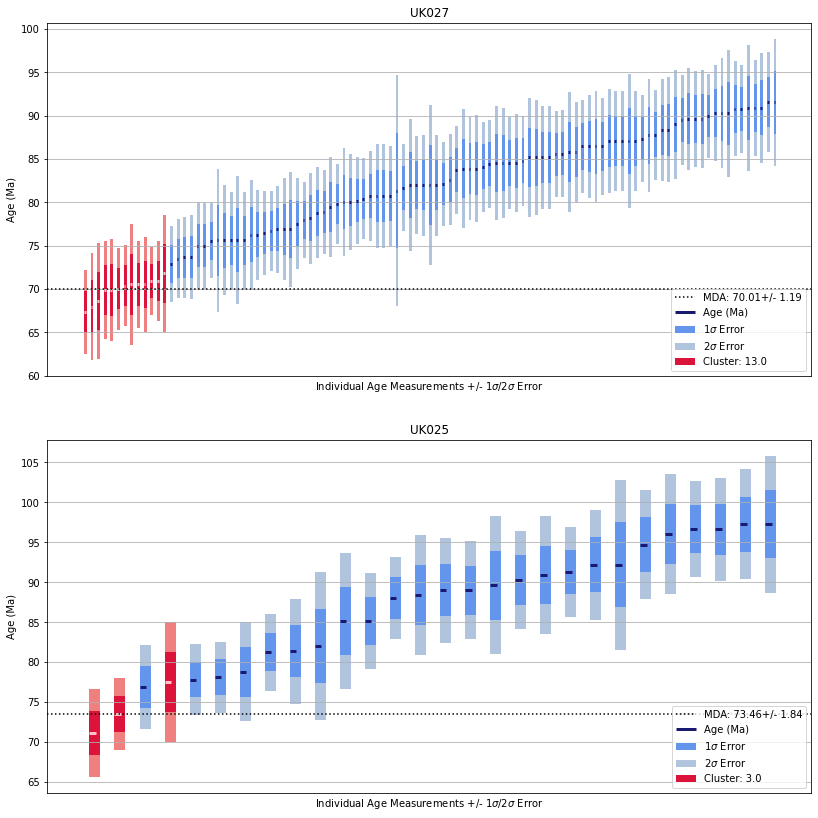

In [12]:
plotwidth = 12
plotheight = 6

#Set up max age plotted on age plots: This number age will be added to the oldest age in the age cluster: giving a max plotting age
age_addition_set_max_plot = 20

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YC1s_MDA, YC1s_Table_ = MDAFunc.YC1s_outputs(ages, errors, sample_list, YC1s_MDA, YC1s_cluster_arrays, plotwidth, plotheight, age_addition_set_max_plot, Image_File_Option, min_cluster_size=2); YC1s_Table_


### 5. YC2$\sigma$ (3+): Youngest Grain Cluster at 2$\sigma$ 
The youngest grain cluster at 2σ uncertainty (YC2σ), is calculated using the weighted mean age, weighted by the square of the age uncertainty (Dickinson and Gehrels, 2009). The grain cluster used within the weighted mean age calculation consists of the youngest three or more grains that overlap within 2σ uncertainty. The uncertainty of the YC2σ MDA is calculated as the standard error of the calculated weighted mean age. 

The YC2σ algorithm outputs a summary table and plots of the age measurements. The table lists by sample, the MDA value, 1σ uncertainty, MSWD, and number of grains within the youngest grain cluster that were included in the weighted mean age calculation. The plots display grain ages and the corresponding 1σ and 2σ uncertainty upper and lower limit bars. The ages are sorted ascendingly and include up to 10 Ma above the oldest age within the youngest grain cluster. The red bars illustrate the grains within the youngest grain cluster. The MDA is shown on the plots as a dashed line.

,YC2$\sigma$_MDA (Ma),YC2$\sigma$_+/-1s,YC2$\sigma$_MSWD,YC2$\sigma$_Grains
UK027,73.19,1.09,1.24,33
UK025,77.38,1.34,1.49,10


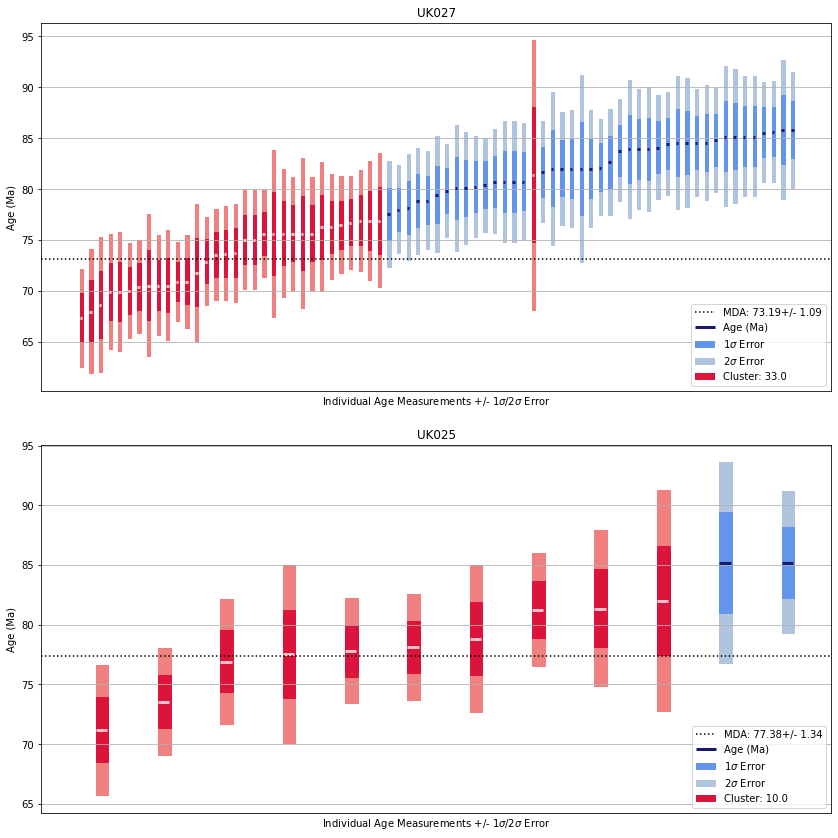

In [13]:
plotwidth= 12
plotheight= 6

#Set up max age plotted on age plots: This number age will be added to the oldest age in the age cluster: giving a max plotting age
age_addition_set_max_plot = 5

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YC2s, YC2s_Table_ = MDAFunc.YC2s_outputs(ages, errors, sample_list, YC2s_MDA, YC2s_cluster_arrays, plotwidth, plotheight, age_addition_set_max_plot, Image_File_Option, min_cluster_size=3); YC2s_Table_

### 6. Y3Zo: Youngest Three Zircons at 2$\sigma$  (Y3Zo) 
The youngest three zircons at 2σ uncertainty (Y3Zo) method calculates an MDA using the weighted mean age of the youngest three zircons that overlap within 2σ uncertainty, weighted by the square of the age uncertainty (Ross et al., 2017). The grain cluster used within the weighted mean age calculation is determined using the youngest grain cluster algorithm, with only the youngest three zircons selected from the cluster. The uncertainty of the Y3Zo MDA is calculated as the standard error of the calculated weighted mean age. The Y3Zo algorithm outputs a summary table, and plots of the age measurements. The table lists by sample, the MDA value, 1σ uncertainty, and the MSWD. The plots display grain ages and the corresponding 1σ and 2σ uncertainty upper and lower limit bars. The ages are sorted ascendingly and include up to 10 Ma above the oldest age within the youngest three grains that overlap at 2σ uncertainty. The red bars illustrate the youngest three grains within the cluster. The MDA is shown on the plots as a dashed line. 

,Y3Zo_MDA (Ma),Y3Zo_+/-1$\sigma$,Y3Zo_MSWD,Y3Zo_Grains
UK027,67.83,1.86,0.05,3
UK025,73.90,1.74,1.16,3


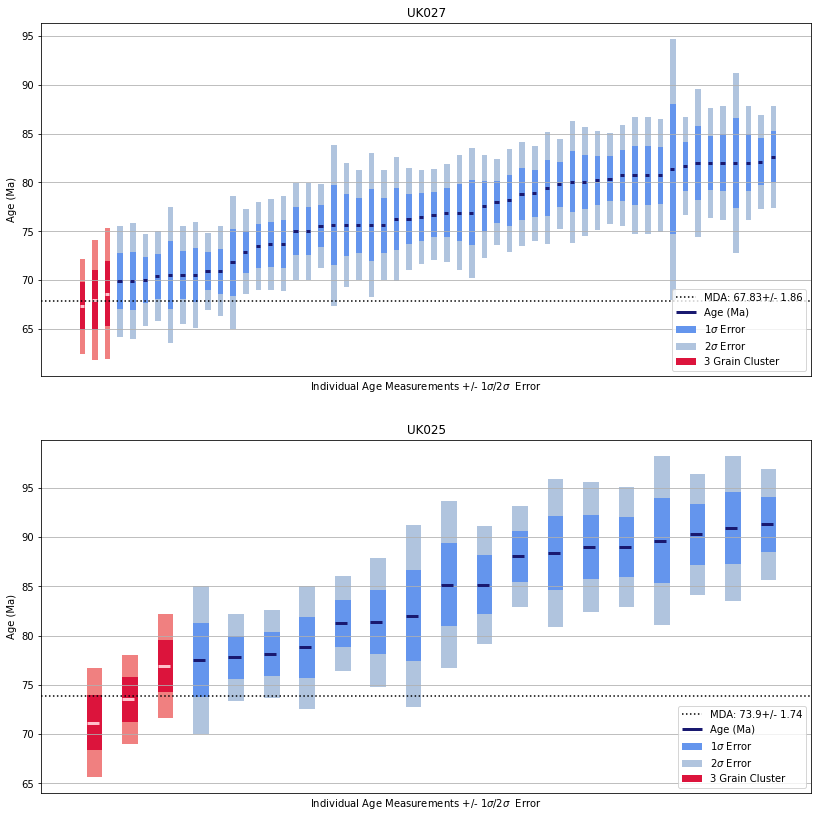

In [14]:
plotwidth= 12
plotheight= 6

#Set up max age plotted on age plots: This number age will be added to the oldest age in the age cluster: giving a max plotting age
age_addition_set_max_plot = 15

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

Y3Zo_MDA, Y3Zo_Table_ = MDAFunc.Y3Zo_outputs(ages, errors, sample_list, Y3Zo_MDA, Y3Zo_cluster_arrays, plotwidth, plotheight, age_addition_set_max_plot, Image_File_Option, min_cluster_size=3); Y3Zo_Table_

### 7. Y3Za: Youngest Three Zircons (Y3Za) 
The youngest three zircons (Y3Za) method calculates an MDA using the weighted mean age of the youngest three zircons, weighted by the square of the age uncertainty (Zhang et al., 2016). To select the three youngest zircons, dates are sorted ascendingly by age and the first three are chosen. The uncertainty of the Y3Za MDA is calculated as the standard error of the calculated weighted mean age. The Y3Za algorithm outputs a summary table, and plots of the age measurements. The table lists by sample, the MDA value, 1σ uncertainty, and the MSWD. The plots display grain ages and the corresponding 1σ and 2σ uncertainty upper and lower limit bars. The ages are sorted ascendingly and include up to 10 Ma above the oldest of the youngest three grains. The red bars illustrate the youngest three grains. The MDA is shown on the plots as a dashed line.

,Y3Za_MDA (Ma),Y3Za_+/-1$\sigma$,Y3Za_MSWD,Y3Za_Grains
UK027,67.83,1.86,0.05,0
UK025,73.90,1.74,1.16,1


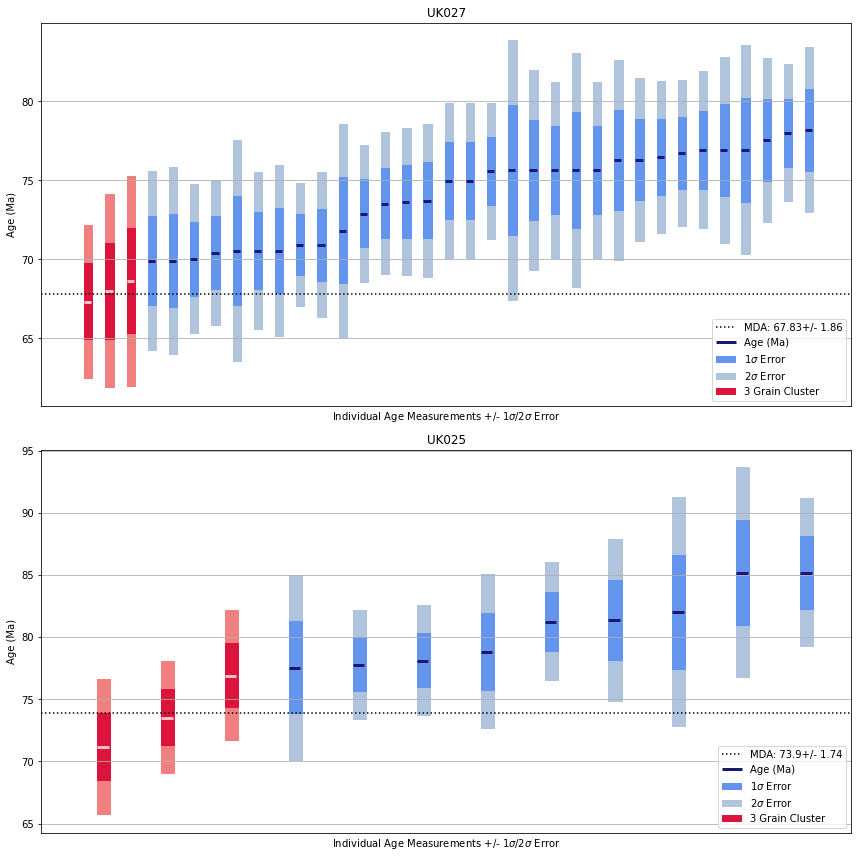

In [15]:
plotwidth= 12
plotheight= 6

#Set up max age plotted on age plots: This number age will be added to the oldest age in the age cluster: giving a max plotting age
age_addition_set_max_plot = 10

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

Y3Za_MDA, Y3Za_Table_ = MDAFunc.Y3Za_outputs(ages, errors, Y3Za_MDA, Y3Za_cluster_arrays, sample_list, plotwidth, plotheight, age_addition_set_max_plot, Image_File_Option); Y3Za_Table_

### 8. The $\tau$ Method 
The $\tau$ method calculates an MDA using the weighted mean age, weighted by the square of the age uncertainty, of all dates that fall between the probability minima (troughs) of the youngest peak composed of a three or more grains on a PDP (Barbeau et al., 2009). The uncertainty of the $\tau$ MDA is calculated as the standard error of the calculated weighted mean age. The $\tau$ algorithm outputs a summary table as well as a PDP for each sample. The table lists by sample, the MDA value, 1σ uncertainty, MSWD, and the number of grains that fall between the probability minima of the youngest peaks and were therefore used in the weighted mean age calculation. The PDPs highlight the MDA value with an intersecting dotted line as well as the grains that fall between the probability minima of the youngest peak (in red). The x-axis is set from 0 to the MDA value + 200 Ma to highlight the youngest peak within the PDP distribution. 

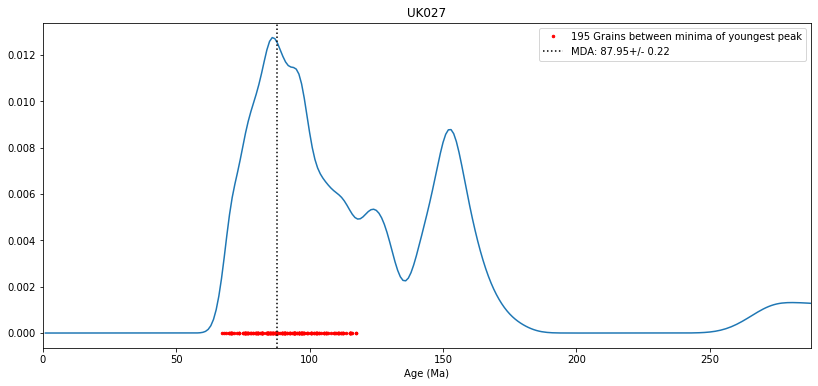

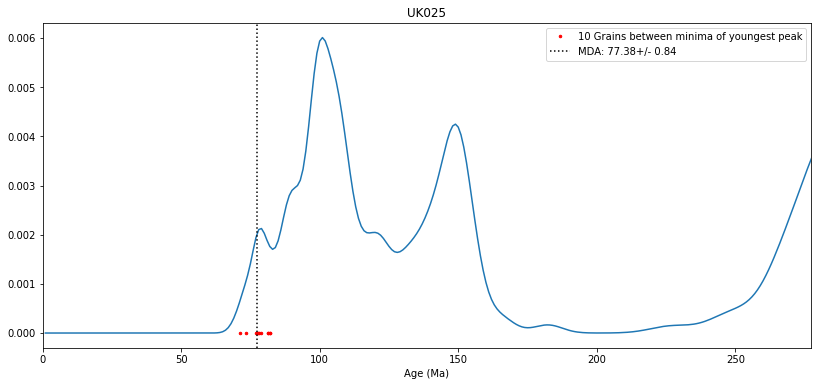

In [20]:
plotwidth=12
plotheight=6

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

Tau_MDA, Tau_Table_ = MDAFunc.Tau_outputs(ages, errors, sample_list, eight_six_ratios, eight_six_error, seven_six_ratios, seven_six_error, U238_decay_constant, U235_decay_constant, U238_U235, Data_Type, best_age_cut_off, plotwidth, plotheight, Image_File_Option, min_cluster_size=3, thres=0.01, minDist=1, xdif=1, x1=0, x2=4000)


### 9. YSP: The Youngest Statistical Population
The youngest statistical population (YSP) method from Coutts et al 2019, calculates an MDA from the weighted mean age, weighted by the square of the age uncertainty, of the youngest two or more grains that produce a MSWD of ~ 1. A MSWD ~1 signals that the dispersion of the age measurements is proportional to the uncertainty of the measurements, and it is reasonable to assume that the grains may be the same true age (Wendt and Carl, 1991). In MDAPy, the sub-sample of grains used in the MDA calculation is selected through a stepwise process. To begin, grains are sorted by age and the MSWD of the two youngest grains is calculated. If the MSWD < 1, more grains are added until the MSWD > 1. The MDA is then calculated from the weighted mean age of this sub-sample of grains. The uncertainty of the MDA is calculated as the standard error of the calculated weighted mean age. The YSP algorithm outputs a summary table, and plots of the age measurements. The table lists by sample, the MDA value, 1σ uncertainty, MSWD, and the number of grains found within the sub-sample of grains used to calculate the MDA. The plots display grain ages and the corresponding 1σ and 2σ uncertainty upper and lower limit bars. The ages are sorted ascendingly and include up to 10 Ma above the oldest of the sub-sample of grains, which are highlighted in red. The MDA is shown on the plots as a dashed line.

,YSP_MDA (Ma),YSP_+/-1$\sigma$,YSP_MSWD,YSP_Grains
UK027,72.33,1.10,1.00,26
UK025,74.38,1.67,1.05,4


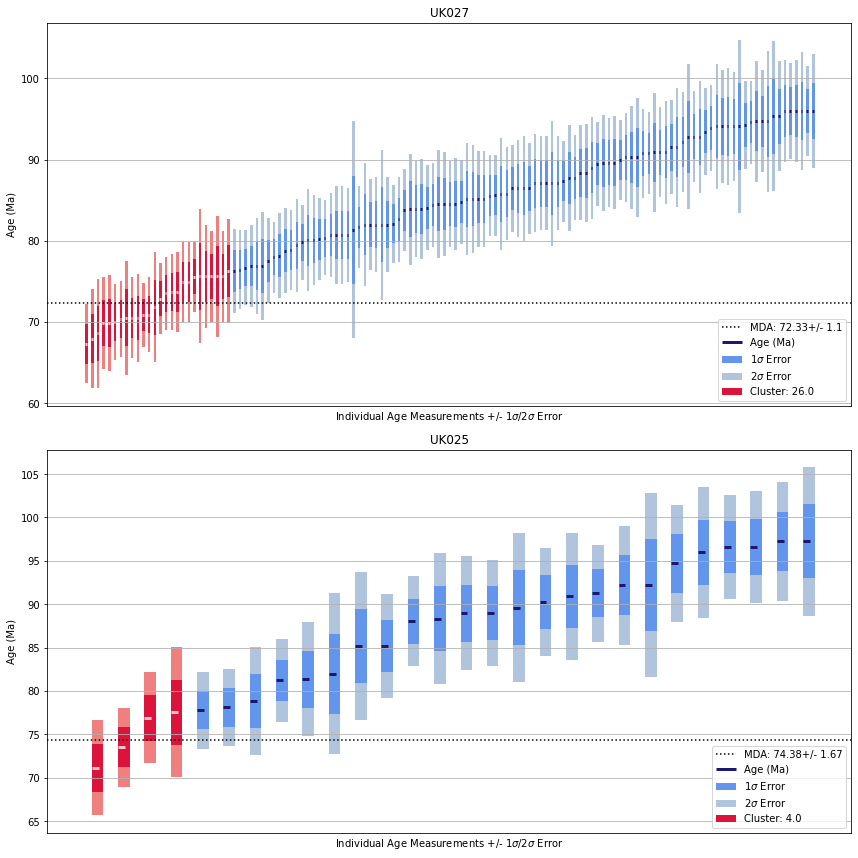

In [16]:
plotwidth=12
plotheight=6

#Set up max age plotted on age plots: This number age will be added to the oldest age in the age cluster: giving a max plotting age
age_addition_set_max_plot = 20

Image_File_Option = 'jpg' #eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

YSP_MDA, YSP_Table_ = MDAFunc.YSP_outputs(ages, errors, sample_list, YSP_MDA, YSP_cluster, plotwidth, plotheight, age_addition_set_max_plot, Image_File_Option, min_cluster_size=2, MSWD_threshold=1); YSP_Table_ 

### 10. The MLA Method

This method developed and tested in Vermeesch (2020), uses a maximum likelihood model that was originally developed for fission track thermochronology by Galbraith and Laslett(1993). The approach parameterises the MDA estimation problem with a binary mixture of discrete and continuous distributions. The ‘Maximum Likelihood Age’ (MLA) algorithm converges to a unique MDA value and is a purely statistical approach to MDA estimation. The results of the MLA method are best visualised on radial plots. 

The radial plot (Galbraith, 1988, 1990) is a graphical device that was specifically designed to display heteroscedastic data, and is constructed as follows. Consider a set of dates {t1, ..., ti, ..., tn} and uncertainties {s[t1], ..., s[ti], ..., s[tn]}. Define zi = z[ti] to be a transformation of ti (e.g., zi = log[ti]), and let s[zi] be its propagated analytical uncertainty (i.e., s[zi] = s[ti]/ti in the case of a logarithmic transformation). Create a scatter plot of (xi, yi) values, where xi = 1/s[zi] and yi = (zi − z◦)/s[zi], where z◦ is some reference value such as the mean. The slope of a line connecting the origin of this scatter plot with any of the (xi, yi)s is proportional to zi and, hence, the date ti. These dates can be more easily visualised by drawing a radial scale at some convenient distance from the origin and annotating it with labelled ticks at the appropriate angles. While the angular position of each data point represents the date, its horizontal distance from the origin is proportional to the precision. Imprecise measurements plot on the left hand side of the radial plot, whereas precise age determinations are found further towards the right. Thus, radial plots allow the observer to assess both the magnitude and the precision of quantitative data in one glance.

The radial plot is a graphical method for displaying and comparing observations that have different precision. Invented by Rex Galbraith in 1988 it is commonly used in geochronology but as also a wide range of applications in business analytics or medical research. The observations are standardised and plotted against precision, with the precision defined as the reciprocal of the standard error. The original observations are given by slopes of lines through the origin and can be read using a circular scale. Radial plots provide a visual representation that can help to assess whether the estimates agree with a common value. They can also be used to identify outliers or groups of estimates differing in a systematic way because of some underlying factor or mixture of populations.

In experimental sciences it is common to have measurements with different precision. This can arise from natural variations or from the experimental procedure. Geochronological methods such as fission track,  40Ar/39Ar , U-Pb and Optically Stimulated Luminescence (OSL) dating produce age estimates and associated errors for each of several grains. The radial plot can be used to display and compare the age estimates and see how they agree or differ within standard statistical variation.

Another application of radial plot is in meta-analysis. Radial plots can be used to compare treatments effects from different clinical studies where the precision of the studies varies.

Due to the nature of this calculation method: systematic uncertainties are NOT added to the final MDA uncertainties 

In [7]:
MDAFunc.MLA_outputs(sample_list, dataToLoad_MLA); 

CalledProcessError: Command '['Rscript', 'R_Scripts/IsoPlotR.R', 'Data/ages_errors_calculated.xlsx', '["UK027", "UK025"]']' returned non-zero exit status 1.